# 고혈압 분석 모델
## @author: sh22h

- year0_NA를 DataFrame으로 불러오고 4개로 나눔
  - binary: 범주형(binary) 변수, 0 / 1 로 변경
  - category: 범주형(>3) 변수, min-max-normalization
  - ctn:연속형 변수, 정규화, 표준화 
  - hyperTension: 고혈압

- 각각 정규화 또는 표준화한 후 변수는 X 고혈압은 Y로 둠
  - 정규화(normalization): 0, 1
  - 표준화(standardization): 평균: 0 표준편차: 1

## 학습 모델

- 1차
  - normalize_ctn
  ```
model = Sequential()
model.add(Dense(12, input_dim=52, activation='relu'))  # input layer requires input_dim param
model.add(Dense(15, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # sigmoid instead of relu for final probability between 0 and 1
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
```

- 2차
  - Decision Tree 구현

- 3차
  - 2021-07-29
  - 식사패턴과 고혈압의 상관 관계

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/year0_NA.csv', index_col=0, na_values=['NA'])
dataset.head()

,AS1_SEX,AS1_AGE,AS1_JOBB,AS1_EDUA,AS1_INCOME,AS1_DRINK,AS1_DRDUA,AS1_TOTALC,AS1_SMOKEA,AS1_HVSMAM,AS1_HVSMDU,AS1_PHYSTB,AS1_PHYSIT,AS1_PHYACTL,AS1_PHYACTM,AS1_PHYACTH,AS1_INSUR,AS1_HEALTH,AS0_TIED,AS1_SLPAMTM,AS0_SLPAMSF,AS1_STRPHYSJ,AS1_RGMEALFQA,AS1_HEIGHT,AS1_WEIGHT,AS1_B01,AS1_B02,AS1_B03,AS1_B04,AS1_B05,AS1_B06,AS1_B07,AS1_B08,AS1_B09,AS1_B10,AS1_B11,AS1_B12,AS1_B13,AS1_B14,AS1_B15,AS1_B16,AS1_B17,AS1_B18,AS1_B19,AS1_B20,AS1_B21,AS1_B23,AS1_B24,P1,P2,P3,P4,HYPERTENSION
RID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
EPI20_026_2_000001,1,69,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,2.0,0.0,0.0,3.0,2.0,1.0,9.0,1.0,1,3.0,NaN,NaN,2140,78,39,371,640,1316,13,3244,807,4440,2,1,14,128,9,2,380,76,4323,27,11,9,145,65,67,965,200,1
EPI20_026_2_000002,0,66,3.0,1.0,1.0,3.0,5.0,NaN,3.0,20.0,45.0,0.0,3.0,6.0,1.0,7.0,2.0,2.0,NaN,7.0,1.0,0,3.0,NaN,NaN,1533,48,22,277,269,698,7,1461,171,1546,1,1,12,53,7,1,124,29,778,9,4,6,94,56,75,735,42,0
EPI20_026_2_000003,0,63,7.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,1.0,2.0,4.0,0.0,7.0,1.0,0,3.0,159.0,66.0,1308,32,11,263,226,521,5,1214,342,2533,1,1,7,53,4,1,136,13,2045,11,4,4,29,12,34,862,19,1
EPI20_026_2_000004,1,56,8.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0,6.0,3.0,8.0,2.0,4.0,1.0,7.0,1.0,0,3.0,NaN,68.0,2649,79,38,494,522,1155,15,3403,640,2574,2,1,20,264,16,2,350,101,3171,18,9,13,335,702,75,735,82,1
EPI20_026_2_000005,0,42,3.0,3.0,5.0,2.0,3.0,0.0,1.0,0.0,0.0,3.0,2.0,0.0,0.0,8.0,2.0,2.0,1.0,8.0,1.0,1,3.0,NaN,NaN,2638,76,31,506,333,1213,14,2645,310,2156,2,1,19,138,10,2,276,23,1677,17,9,10,111,470,10,1070,14,0


In [ ]:
# 식이패턴과 고혈압의 연관관계 조사
pattern = dataset.reindex(columns=['P1', 'P2', 'P3', 'P4'])
normalize_pattern = (pattern - pattern.min()) / (pattern.max() - pattern.min())
standarizied_pattern = pattern.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

(9704, 4)
(9704, 4)


In [ ]:
# X = normalize_pattern # min-max
X = standarizied_pattern # gausian
y = dataset['HYPERTENSION']  # 고혈압 변수

# 훈련 데이터 나눔
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8733, 4) (971, 4) (8733,) (971,)


In [ ]:
model = Sequential()
# model.add(Dense(120, input_dim=52, activation='relu'))  # input layer requires input_dim param
model.add(Dense(12, input_dim=4, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # sigmoid instead of relu for final probability between 0 and 1

# compile the model, adam gradient descent (optimized)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

# call the function to fit to the data (training the network)
# verbose=0 는 프로그래스를 숨깁니다.
history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
# print(history.history)

# 모델의 정확도를 계산합니다.
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

31/31 [==============================] - 0s 1ms/step - loss: 0.5418 - accuracy: 0.7745
accuracy: 77.45%


[Text(0, 0.5, 'loss'), Text(0.5, 0, 'epoch'), Text(0.5, 1.0, 'model loss')]

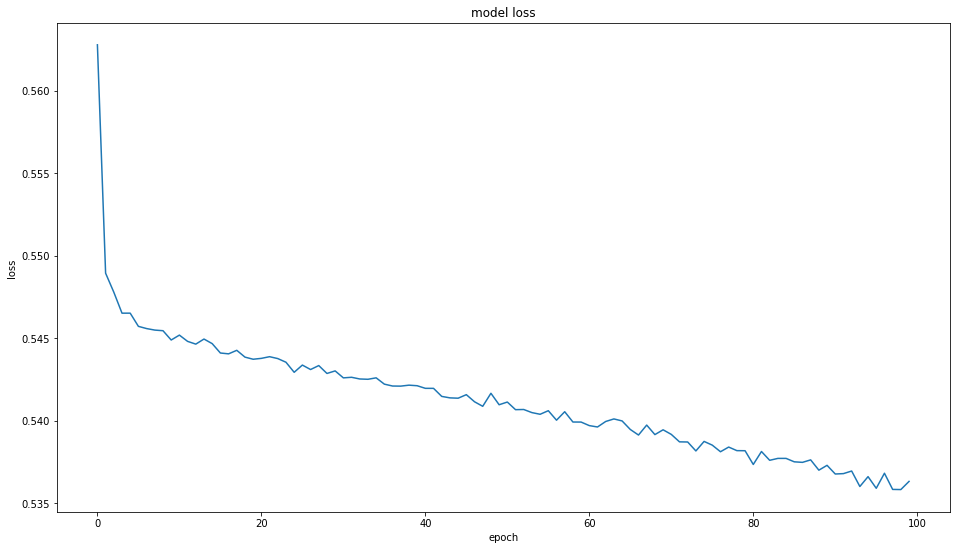

In [ ]:
fig, ax = plt.subplots()

# 모델의 오차를 그립니다.
ax.plot(history.history['loss'])
ax.set(title='model loss', xlabel='epoch', ylabel='loss')

## Decision Tree

### 하이퍼 파라미터

- min_samples_split
  - 노드를 분할하기 위한 최소한의 샘플 데이터 수로 과적합 제어에 사용.
  - default는 2이다. 작게 설정할수록 분할되는 노드가 많아져 과적합 가능성 증가.
- min_samples_leaf
  - 말단 노드가 되기위한 최소한의 샘플 수
  - 과적합 제어 용도. 비대칭적 데이터의 경우 특정 클래스의 데이터가 극도로 작을 수 있어 이 경우에는 작게 설정.
- max_features
  - 최적의 분할을 위해 고려할 최대 feature 개수. default는 None으로 데이터 세트의 모든 feature을 사용하여 분할.
  - int로 지정 시 대상 feature 개수, float로 지정 시 전체 feature중 대상 feature의 퍼센트
  - sqrt는 전체 feature중 제곱근 값.
  - auto는 sqrt와 동일
  - log는 전체 featur을 log2()로 선정
- max_depth
  - 트리의 최대 깊이 지정
  - default는 None. 이는 완벽히 클래스 결정값이 될때 까지 깊이를 계속 키우거나 노드가 가지는 데이터 개수가 min_samples_split보다 작아질 때 까지 계속 분할
  - 깊이가 깊어지면 min_samples_split 설정대로 최대 분할하여 과적합할 수 있으므로 적당한 값으로 제어.
- max_leaf_nodes
  - 말단 노드 최대 개수

- 출처: https://velog.io/@lsmmay322/%EA%B2%B0%EC%A0%95%ED%8A%B8%EB%A6%ACDecision-Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
print("훈련 세트 정확도: {:.3f}".format(tree.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(tree.score(X_test, y_test)))

훈련 세트 정확도: 0.764
테스트 세트 정확도: 0.775


In [ ]:
importances = tree.feature_importances_
print("특성 중요도:\n{}".format(importances))

특성 중요도:
[0.1169421  0.         0.35612478 0.52693312]


Text(0, 0.5, 'feature importance')

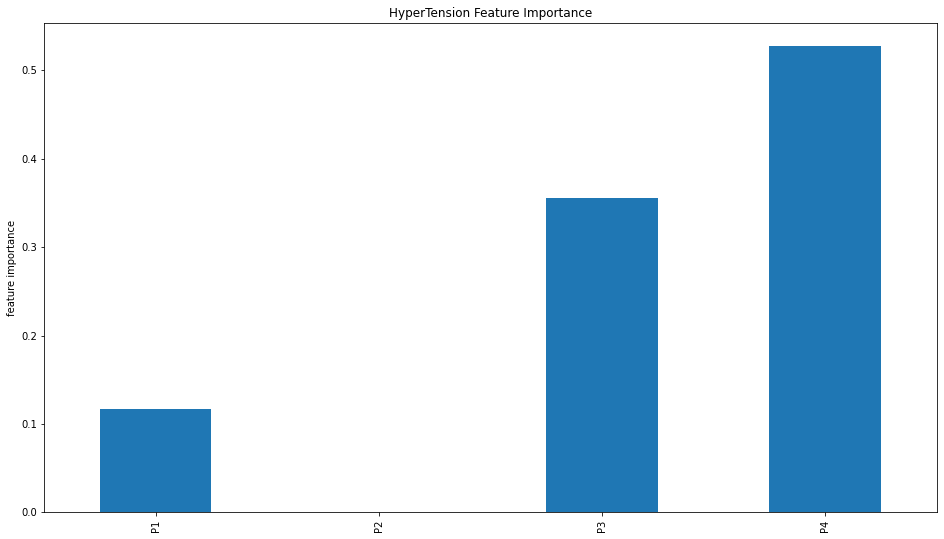

In [ ]:
tree_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
tree_importances.plot.bar(ax=ax)
ax.set_title("HyperTension Feature Importance")
ax.set_ylabel("feature importance")

In [ ]:
export_graphviz(
    tree,
    out_file=("./tree.dot")
)

!ls

drive  sample_data  tree.dot  tree.png


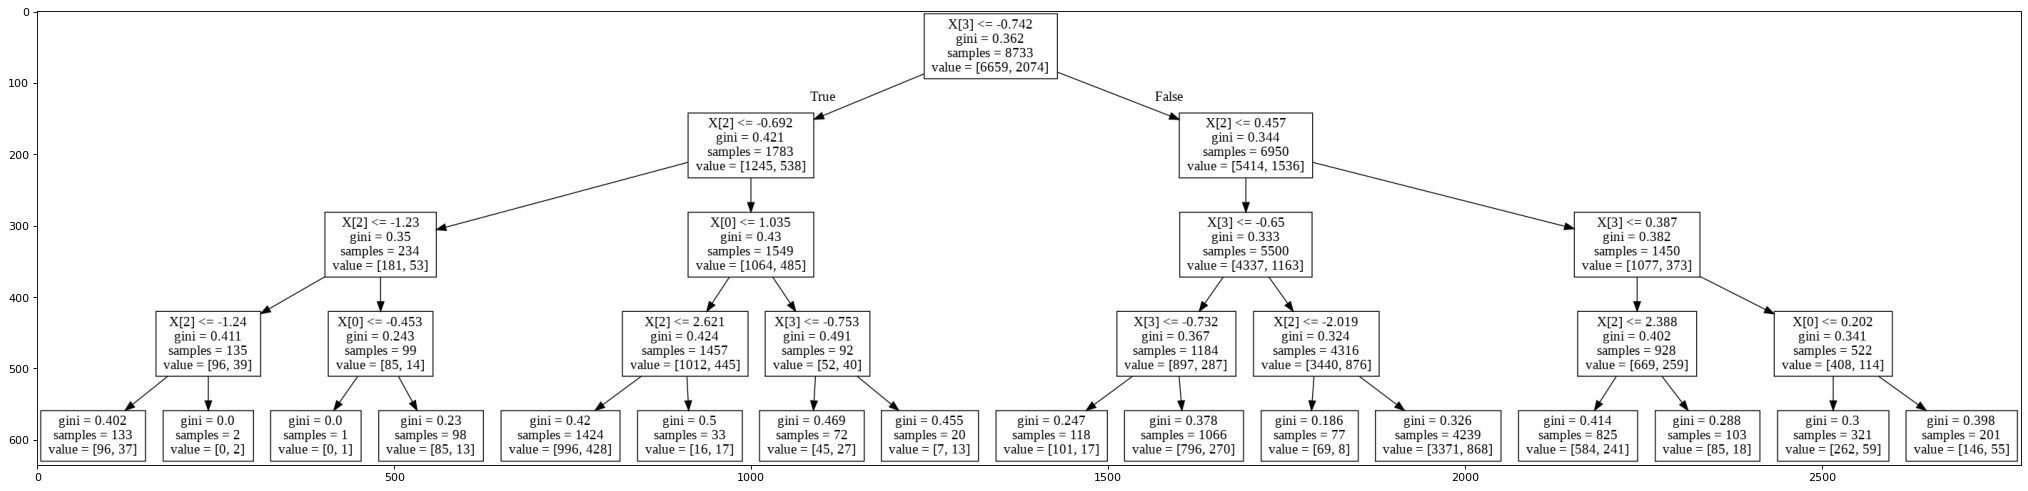

In [ ]:
!dot -Tpng tree.dot -o tree.png

tree_img = plt.imread('./tree.png')

plt.figure(num=None, figsize=(32, 9), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(tree_img)